In [1]:
___Author___='LumberJack Jyss'
print('Global Optimized LumberJack Environment Motor\n°OoO_FXCM_Oo0°\nLumberJack Jyss 5779(c)')
print('Version v2.02')
print('Importing librairies...')
import forexconnect
from forexconnect import fxcorepy
from forexconnect import ForexConnect, ResponseListener, Common
import time
import sys
import numpy as np
import pandas as pd
from colorama import Fore, Back, Style 
import datetime as dt
import talib
print('Librairies imported')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


def session_status_changed(session: fxcorepy.O2GSession,
                           status: fxcorepy.AO2GSessionStatus.O2GSessionStatus):
    print("Trading session status: " + str(status))
    return



pos_long_SPX500 = 0
pos_short_SPX500 = 0

global trigger 
trigger = 0

# TOKEN = 'e053ac1597cef331df9429ac8151100ea9f1c411'
# server = 'demo'
user_id = 'D261151986'
password = '2786'
url = 'fxcorporate.com/Hosts.jsp'
accountid='01147539'
# minutes: 'm1' , 'm5' , 'm15' , 'm30' 
# hours: 'H1' , 'H2', 'H3', 'H4', 'H6' 'H8'
# one day: 'D1'
# one week: 'W1'
# one month: 'M1'
ticker = 'SPX500'
period = 'm1'
number = 30
jet_lag = -2
amount_SPX500 = 30
buysell_SPX500 = None
side_SPX500 = None
trade_id_SPX500 = None
open_rate_SPX500 = None
open_time_SPX500 = None
offerid_SPX500 = None
pnl_SPX500 = None
last_aroonup = 0
last_aroondown = 0
last_aroondelta = 0
blok = 0



# Time Windows
# start = dt.datetime(2017, 7, 15)
# stop = dt.datetime(2017, 8, 1)
# con.get_candles('EUR/USD', period='D1',start=start, stop=stop)

# CONNEXION

fx = ForexConnect()
fx.login(user_id, password, url,"Demo", session_status_callback=session_status_changed)
table_manager = fx.table_manager
trades_table = table_manager.get_table(fx.TRADES)

# RECOVERING TEST
for row in trades_table:
    if row['trade_id'] == trade_id_SPX500 and row['buy_sell'] == 'B':
        pos_long_SPX500 = 1
    elif row['trade_id'] == trade_id_SPX500 and row['buy_sell'] == 'S':
        pos_short_SPX500 = 1

# RECCUPERATION DES 30 DERNIERES DONNEES

def scrap_data(df):
    history = fx.get_history(ticker, period,quotes_count=number)
    df = pd.DataFrame({'Date':history['Date'],'Open':history['BidOpen'],'High':history['BidHigh'],'Low':history['BidLow'],'Close':history['BidClose']})
    return(df)

def prep_data(df):
    rsi = talib.RSI(df['Close'],timeperiod=2)
    aroondown, aroonup = talib.AROON(df['High'], df['Low'], timeperiod=14)
    aroondelta = aroonup - aroondown #(aroonup-aroondown)/abs((aroonup-aroondown))
    ema20 = talib.EMA(df['Close'],timeperiod=20)
    sar = talib.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
    atr = talib.ATR(df['High'], df['Low'],df['Close'],timeperiod=14)
    df['RSI'] = rsi
    df['Aroon Up'] = aroonup
    df['Aroon Down'] = aroondown
    df['Delta Aroon'] = aroondelta
    df['EMA20'] = ema20
    df['SAR'] = sar
    df['ATR'] = atr
    df['Bid_Close'] = df['Close']
    #df = df.drop(['Open','High','Low','Close'],axis=1)
    return (df)



def trace_it(df):
    global trigger
    #trigger = 1
    plt.figure(figsize=(26,8))
    plt.plot(df.iloc[:,-1],c='orange',alpha=0.5,linewidth=0.5)
    pos_long_SPX500 = 0
    pos_short_SPX500 = 0
    blok = 0
    for i in range(0,len(df)-1):
        
        if pos_short_SPX500 > 1 or pos_long_SPX500 > 1 or trigger > 1:
            print('Error - ',pos_short_SPX500,pos_long_SPX500, trigger)
        
        elif df.iloc[i,5] > 90 and df.iloc[i,7] < 25 and df.iloc[i,6]  > 90 and trigger == 0 and pos_short_SPX500 == 1 and pos_long_SPX500 == 0 and (df.iloc[i,-1] - blok) < -2 :

            plt.scatter(x=i,y=df.iloc[i,-1],c='cyan',marker='x')
            pos_short_SPX500 = 0
            trigger = trigger + 1



        elif df.iloc[i,5] > 90 and df.iloc[i,7]  < 25 and df.iloc[i,6]  > 90 and trigger == 0 and pos_short_SPX500 == 0 and pos_long_SPX500 == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='g',marker='o',alpha=0.7)
            pos_long_SPX500 = 1
            blok = df.iloc[i,-1]
            trigger = trigger + 1


        elif df.iloc[i,5] < 25 and df.iloc[i,6] < 25 and df.iloc[i,7] > 80 and trigger == 1 and pos_long_SPX500 == 1 and pos_short_SPX500 == 0 and (df.iloc[i,-1] - blok) > 20:
            
            plt.scatter(x=i,y=df.iloc[i,-1],c='b',marker='x')
            pos_long_SPX500 = 0
            trigger = trigger - 1

        elif df.iloc[i,5] < 25 and df.iloc[i,6] < 25 and df.iloc[i,8] > -30 and trigger == 1 and pos_long_SPX500 == 0 and pos_short_SPX500 == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='red',marker='o',alpha=0.4)
            pos_short_SPX500 = 1
            trigger = trigger - 1
            blok = df.iloc[i,-1]
                    
    return


    
tmps1=time.time()
df = pd.DataFrame()
df = scrap_data(df)
print('\033[33m' + 'Initializing GOLEM...')
print('\033[35m' +'Long Pos =',pos_long_SPX500)
print('Short Pos =',pos_short_SPX500,Style.RESET_ALL)
tmps2=round(time.time()-tmps1,2)
print('Data scraped in ',tmps2,' seconds')


# DATA PREPARATION
tmps1=time.time()
print('df.shape control : ',df.shape)
prep_data(df)
tmps2=round(time.time()-tmps1,2)
print('Data prepared in ',tmps2,' seconds')

#df.reset_index(inplace=True,drop=True)
#df = df.dropna()

print('\033[36m'+'GOLEM begins Computing...'+Style.RESET_ALL)


print('Computing done')
print('Instrument :', ticker)
print(df.tail())

#print('computing graph')
#trace_it(df)

for loop in range (0,200000):
    
    df = scrap_data(df)
    df = prep_data(df)


    last_aroonup = df.iloc[-1,6]
    last_aroondown = df.iloc[-1,7]
    last_aroondelta = df.iloc[-1,8]

    print('\r \033[43m '+period+' \033[0m'+'\033[46m'+'...'+'\033[0m',end='')
    print ('\033[36m', dt.datetime.now().hour+jet_lag,'H',dt.datetime.now().minute,'min',dt.datetime.now().second,'sec',Style.RESET_ALL,'loop : ',loop,end='')
    print(' - Bid : ',float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]),end='')
    print(' - Ask : ',float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]),end='')
    print(' - Aroon Up : ',last_aroonup,end='')
    print(' - Aroon Down : ',last_aroondown,end='')
    print(' - Delta Aroon : ',last_aroondelta,end='')
    #if pos_long_SPX500 == 1:
    #    try:
    #        if pnl_SPX500 > 0 :
    #            print('\033[42m  - pnl : ',round(pnl_SPX500,2),'\033[0m',end='', flush=True)
    #        elif pnl_SPX500 < 0:
    #            print('\033[41m  - pnl : ',round(pnl_SPX500,2),'\033[0m',end='', flush=True)
    #    except:
    #        pass
    #elif pos_short_SPX500 == 1:
    #    try:
    #        if pnl_SPX500 > 0 :
    #            print('\033[42m  - pnl : ',round(pnl_SPX500,2),'\033[0m',end='', flush=True)
    #        elif pnl_SPX500 < 0:
    #            print('\033[41m  - pnl : ',round(pnl_SPX500,2),'\033[0m',end='', flush=True)
    #    except:
    #        pass
    
    
    #############

    if pos_short_SPX500 == 1000 and (df.iloc[-1,-1] - blok) < -2:
        try:
            pos_short_SPX500 = 0
            trigger = trigger - 1
            buysell_SPX500 = 'B'
            trade_rate_SPX500 = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            request_close_SPX500 = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_SPX500,
                                                                    BUY_SELL=buysell_SPX500,
                                                                    AMOUNT=amount_SPX500,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_SPX500)
            resp_close_SPX500 = fx.send_request(request_close_SPX500)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_SPX500:
                    trade =None
                    side_SPX500 = row['buy_sell']
                    pnl_SPX500 = row['pl']
                    trade_id_SPX500 = row['trade_id']
                    open_rate_SPX500 = row['open_rate']
                    amount_SPX500 = row['amount']
                    open_time_SPX500 = row['open_time']
                    close_rate_SPX500 = row['close_rate']
                    close_time_SPX500 = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_SPX500,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_SPX500)
            print('Open Rate : ',open_rate_SPX500)
            print('Amount : ',amount_SPX500)
            print('')


        except:
            print("WARNING! It wasn't possible to close the position" ,end='')
            pass

    if df.iloc[-1,5] > 99 and df.iloc[-1,6] == 100 and df.iloc[-1,7] < 10 and df.iloc[-1,8] > 20 and pos_short_SPX500 == 0 and (df.iloc[-1,-1] - blok) > 10 and trigger == 1:
        try:
            pos_long_SPX500 = 0
            trigger = trigger - 1
            buysell_SPX500 = 'S'
            trade_rate_SPX500 = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            request_close_SPX500 = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_SPX500,
                                                                    BUY_SELL=buysell_SPX500,
                                                                    AMOUNT=amount_SPX500,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_SPX500)
            resp_close_SPX500 = fx.send_request(request_close_SPX500)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_SPX500:
                    trade =None
                    side_SPX500 = row['buy_sell']
                    pnl_SPX500 = row['pl']
                    trade_id_SPX500 = row['trade_id']
                    open_rate_SPX500 = row['open_rate']
                    amount_SPX500 = row['amount']
                    open_time_SPX500 = row['open_time']
                    close_rate_SPX500 = row['close_rate']
                    close_time_SPX500 = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_SPX500,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_SPX500)
            print('Open Rate : ',open_rate_SPX500)
            print('Amount : ',amount_SPX500)
            print('')


        except:
            print("WARNING! It wasn't possible to close the position" ,end='')
            pass

    if df.iloc[-1,5] < 1.1 and df.iloc[-1,6] < 15 and df.iloc[-1,7] > 85 and df.iloc[-1,8] < -20 and pos_short_SPX500 == 0 and pos_long_SPX500 == 0 and trigger == 0:
        try:
            buysell_SPX500 = 'B'
            trade_rate_SPX500 = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            print('Trying Long at :',trade_rate_SPX500)

            request_open_SPX500 = fx.create_order_request(\
                SYMBOL=ticker,\
                order_type='OM',\
                ACCOUNT_ID=accountid,\
                BUY_SELL=buysell_SPX500,\
                AMOUNT=amount_SPX500,\
                TIME_IN_FORCE='IOC'\
                )
            resp_open_SPX500 = fx.send_request(request_open_SPX500)
            order_id_SPX500 = resp_open_SPX500.order_id
            offer_SPX500 = Common.get_offer(fx,ticker)
            offerid_SPX500 = offer_SPX500.offer_id
            table_manager = fx.table_manager
            trades_table = table_manager.get_table(fx.TRADES)
            print('Actualisation des tables')
            time.sleep(0.5)
            for row in trades_table:
                side_SPX500 = row['buy_sell']
                pnl_SPX500 = row['pl']
                trade_id_SPX500 = row['trade_id']
                open_rate_SPX500 = row['open_rate']
                amount_SPX500 = row['amount']
                print('Side',side_SPX500,'pnl : ',pnl_SPX500,'Trade_ID : ',trade_id_SPX500,'Open_Rate',open_rate_SPX500,'Amount',amount_SPX500)

            print('Résumé : ')
            print(' Open date : ', open_time_SPX500)
            print('Open Rate : ',open_rate_SPX500)
            print('Amount : ',amount_SPX500)
            print('pnl : ',pnl_SPX500)
            print('Order : ',trade_id_SPX500)
            print('')
            print('                                                    Go Long!')
            pos_long_SPX500 = 1
            blok = df.iloc[-1,-1]
            trigger = trigger + 1

        except:
            print("It wasn't possible to long... What a good opportunity missed... Meoow yells the black cat",end='')
            pass

        if df.iloc[-1,5] > 900:
            try:
                buysell_SPX500 = 'S'
                trade_rate_SPX500 = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
                print('Trying Short at :',trade_rate_SPX500)

                request_open_SPX500 = fx.create_order_request(\
                    SYMBOL=ticker,\
                    order_type='OM',\
                    ACCOUNT_ID=accountid,\
                    BUY_SELL=buysell_SPX500,\
                    AMOUNT=amount_SPX500,\
                    TIME_IN_FORCE='IOC'\
                    )
                resp_open_SPX500 = fx.send_request(request_open_SPX500)
                order_id_SPX500 = resp_open_SPX500.order_id
                offer_SPX500 = Common.get_offer(fx,ticker)
                offerid_SPX500 = offer_SPX500.offer_id
                table_manager = fx.table_manager
                trades_table = table_manager.get_table(fx.TRADES)
                print('Actualisation des tables')
                time.sleep(0.5)
                for row in trades_table:
                    side_SPX500 = row['buy_sell']
                    pnl_SPX500 = row['pl']
                    trade_id_SPX500 = row['trade_id']
                    open_rate_SPX500 = row['open_rate']
                    amount_SPX500 = row['amount']
                    print('Side',side_SPX500,'pnl : ',pnl_SPX500,'Trade_ID : ',trade_id_SPX500,'Open_Rate',open_rate_SPX500,'Amount',amount_SPX500)

                print('Résumé : ')
                print(' Open date : ', open_time_SPX500)
                print('Open Rate : ',open_rate_SPX500)
                print('Amount : ',amount_SPX500)
                print('pnl : ',pnl_SPX500)
                print('Order : ',trade_id_SPX500)
                print('')
                print('                                                    Go Short!')
                pos_short_SPX500 = 1
                blok = df.iloc[-1,-1]
                trigger = trigger + 1


            except:
                print("It wasn't possible to long... What a good opportunity missed... Meoow yells the black cat",end='')
                pass

    
    ###########@
    

Global Optimized LumberJack Environment Motor
°OoO_FXCM_Oo0°
LumberJack Jyss 5779(c)
Version v2.02
Importing librairies...
Librairies imported
Trading session status: CONNECTING
Trading session status: CONNECTED
Initializing GOLEM...
Long Pos = 0
Short Pos = 0 
Data scraped in  1.01  seconds
df.shape control :  (30, 5)
Data prepared in  0.01  seconds
GOLEM begins Computing...
Computing done
Instrument : SPX500
                  Date     Open     High      Low    Close        RSI  \
25 2019-07-11 14:04:00  2999.00  2999.00  2996.36  2996.50   2.473383   
26 2019-07-11 14:05:00  2996.50  2996.94  2995.11  2996.44   2.371473   
27 2019-07-11 14:06:00  2996.44  2996.94  2995.36  2996.73  30.180175   
28 2019-07-11 14:07:00  2996.73  2996.73  2995.86  2996.68  27.480957   
29 2019-07-11 14:08:00  2996.68  2996.68  2996.38  2996.61  21.977330   

     Aroon Up  Aroon Down  Delta Aroon        EMA20          SAR       ATR  \
25   7.142857  100.000000   -92.857143  2998.912387  3000.610336  1.2

KeyboardInterrupt: 

In [5]:
df.iloc[-1,5],df.iloc[-1,6],df.iloc[-1,7]

(98.611987361206, 100.0, 14.285714285714286)

In [ ]:
# RSI < 1.1 UP < 15 DWN >85 DELTA -29

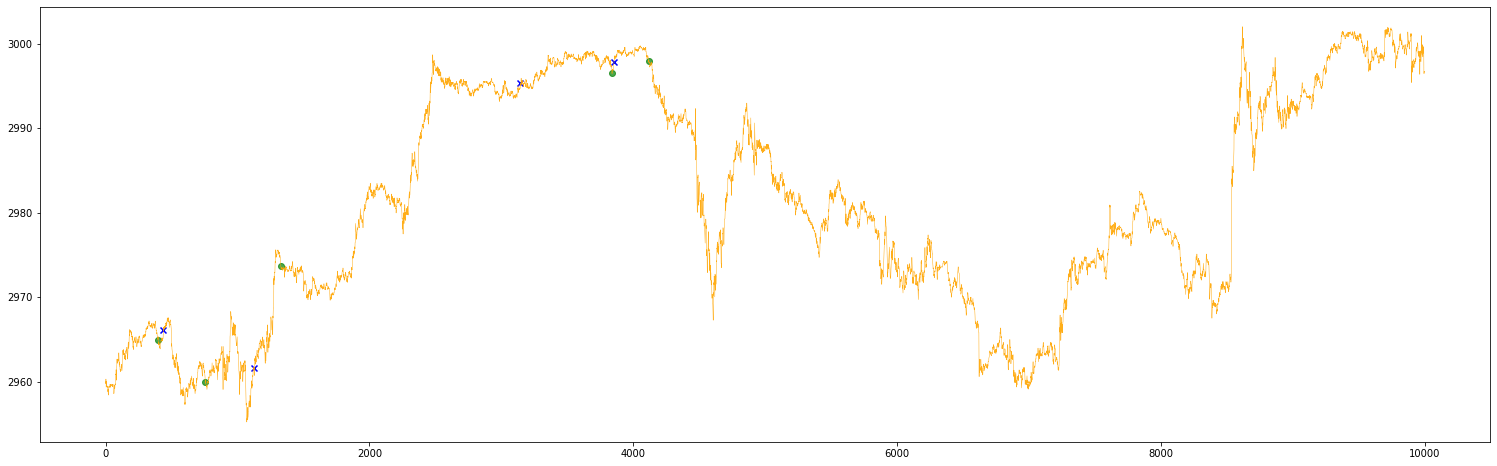

In [3]:
number = 10000
df = scrap_data(df)
df = prep_data(df)
def trace_it3(df):
    trigger = 0
    plt.figure(figsize=(26,8))
    plt.plot(df.iloc[:,-1],c='orange',alpha=0.9,linewidth=0.5)
    pos_long_SPX500 = 0
    pos_short_SPX500 = 0
    blok = 0
    for i in range(0,len(df)-1):
        
        #if pos_short_SPX500 > 1 or pos_long_SPX500 > 1 or trigger > 1:
        #    print('Error - ',pos_short_SPX500,pos_long_SPX500, trigger)
        
        
        if df.iloc[i,5] < 1.1 and df.iloc[i,6] < 150 and df.iloc[i,7] > 85 and df.iloc[i,8] < -20 and pos_short_SPX500 == 1 and pos_long_SPX500 == 0 and (df.iloc[i,-1] - blok) < -15 and trigger == 1:

            plt.scatter(x=i,y=df.iloc[i,-1],c='cyan',marker='x')
            pos_short_SPX500 = 0
            trigger = 0
            
        
        if df.iloc[i,5] > 99 and df.iloc[i,6] == 100 and df.iloc[i,7] < 10 and df.iloc[i,8] > 20 and pos_short_SPX500 == 0 and (df.iloc[i,-1] - blok) > 1 and trigger == 1:
            
            plt.scatter(x=i,y=df.iloc[i,-1],c='b',marker='x')
            pos_long_SPX500 = 0
            trigger = 0



        if df.iloc[i,5] < 1.1 and df.iloc[i,6] < 15 and df.iloc[i,7] > 85 and df.iloc[i,8] < -20 and pos_short_SPX500 == 0 and pos_long_SPX500 == 0 and trigger == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='g',marker='o',alpha=0.7)
            pos_long_SPX500 = 1
            blok = df.iloc[i,-1]
            trigger = 1


        if df.iloc[i,5] > 990 and df.iloc[i,6] == 100 and df.iloc[i,7] < 10 and df.iloc[i,8] > 20 and pos_long_SPX500 == 0 and pos_short_SPX500 == 0 and trigger == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='red',marker='o',alpha=0.7)
            pos_short_SPX500 = 1
            trigger = 1
            blok = df.iloc[i,-1]
                    
    return
trace_it3(df)